In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('../../notebook_format')
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = ( 10.0, 8.0 ) # set default size of plots

# magic so that the notebook will reload external python modules
%load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd

# Quick Recap From the Course Note

## Linear Classification

Let's assume a training dataset of images $x_i \in R^D$, each associated with a label $y_i$. Here $i = 1 \dots N$ and $y_i \in { 1 \dots K }$. That is, we have N examples (each with a dimensionality D) and K distinct categories. For example, in CIFAR-10 we have a training set of N = 50,000 images, each with D = 32 x 32 x 3 = 3072 pixels, and K = 10, since there are 10 distinct classes (dog, cat, car, etc). We will now define the score function $f: R^D \mapsto R^K$ that maps the raw image pixels to class scores.

Linear classifier. In this module we will start out with arguably the simplest possible function, a linear mapping:

$$ f(x_i, W, b) = W x_i + b $$

In the above equation, we are assuming that the image $x_i$ has all of its pixels flattened out to a single column vector of shape [D x 1]. The matrix W (of size [K x D]), and the vector b (of size [K x 1]) are the parameters of the function. In CIFAR-10, $x_i$ contains all pixels in the $i_{th}$ image flattened into a single [3072 x 1] column, W is [10 x 3072] and b is [10 x 1], so 3072 numbers come into the function (the raw pixel values) and 10 numbers come out (the class scores). The parameters in W are often called the weights, and b is called the bias vector because it influences the output scores, but without interacting with the actual data $x_i$. However, you will often hear people use the terms weights and parameters interchangeably.

Note that the single matrix multiplication $W x_i$ is effectively evaluating 10 separate classifiers in parallel (one for each class), where each classifier is a row of W.

**Bias trick:** Before moving on we want to mention a common simplifying trick to representing the two parameters $W,b$ as one. Recall that we defined the score function as:

$$ f(x_i, W, b) = W x_i + b $$

As we proceed through the material it is a little cumbersome to keep track of two sets of parameters (the biases $b$ and weights $W$ separately. A commonly used trick is to combine the two sets of parameters into a single matrix that holds both of them by extending the vector $x_i$ with one additional dimension that always holds the constant $1$ - a default bias dimension. With the extra dimension, the new score function will simplify to a single matrix multiply:

$$ f(x_i, W) = W x_i $$

With our CIFAR-10 example, $x_i$ is now [3073 x 1] instead of [3072 x 1] - (with the extra dimension holding the constant 1), and $W$ is now [10 x 3073] instead of [10 x 3072]. The extra column in $W$ now corresponds to the bias $b$.

## Multiclass Support Vector Machine Loss

The SVM loss is set up so that the SVM "wants" the correct class for each image to a have a score higher than the incorrect classes by some fixed margin $\Delta$.

Let's now get more precise. Recall that for the $i_{th}$ example we are given the pixels of image $x_i$ and the label $y_i$ that specifies the index of the correct class. The score function takes the pixels and computes the vector $f(x_i, W)$ of class scores, which we will abbreviate to $s$ (short for scores). For example, the score for the $j_{th}$ class is the $j_{th}$ element: $s_j = f(x_i, W)_j$. The Multiclass SVM loss for the $i_{th}$ example is then formalized as follows:

$$ L_i = \sum_{j\neq y_i} \max(0, s_j - s_{y_i} + \Delta) $$

Example. Lets unpack this with an example to see how it works. Suppose that we have three classes that receive the scores $s = [13, -7, 11]$, and that the first class is the true class (i.e. $y_i = 0$). The expression above sums over all incorrect classes $(j \neq y_i)$, so we get two terms:

$$ L_i = \max(0, -7 - 13 + 10) + \max(0, 11 - 13 + 10) $$

You can see that the first term gives zero since [-7 - 13 + 10] gives a negative number, which is then thresholded to zero with the $max(0,-)$ function. We get zero loss for this pair because the correct class score (13) was greater than the incorrect class score (-7) by at least the margin 10. In fact the difference was 20, which is much greater than 10 but the SVM only cares that the difference is at least 10; Any additional difference above the margin is clamped at zero with the max operation. The second term computes [11 - 13 + 10] which gives 8. That is, even though the correct class had a higher score than the incorrect class (13 > 11), it was not greater by the desired margin of 10. The difference was only 2, which is why the loss comes out to 8 (i.e. how much higher the difference would have to be to meet the margin). In summary, the SVM loss function wants the score of the correct class $y_i$ to be larger than the incorrect class scores by at least by $\Delta$ (delta) (In the implementation, $\Delta$ is set directly as 1 ). If this is not the case, we will accumulate loss.

Note that in this particular module we are working with linear score functions $f(x_i; W) = W x_i$, so we can also rewrite the loss function in this equivalent form:

$$ L_i = \sum_{j\neq y_i} \max(0, w_j^T x_i - w_{y_i}^T x_i + \Delta) $$

A last piece of terminology we'll mention before we finish with this section is that the threshold at zero $max(0,-)$ function is often called the **hinge loss**. You'll sometimes hear about people instead using the squared hinge loss SVM (or L2-SVM), which uses the form $max(0,-)^2$ that penalizes violated margins more strongly (quadratically instead of linearly). The unsquared version is more standard, but in some datasets the squared hinge loss can work better. This can be determined during cross-validation.

## Optimization

Setting of the parameters $W$ that produced predictions for examples $x_i$ consistent with their ground truth labels $y_i$ would also have a very low loss $L$. We are now going to introduce the third and last key component: optimization using gradient

Lets use the example of the SVM loss function for a single datapoint:

$$ L_i = \sum_{j\neq y_i} \left[ \max(0, w_j^Tx_i - w_{y_i}^Tx_i + \Delta) \right] $$

We can differentiate the function with respect to the weights. For example, taking the gradient with respect to $w_{y_i}$ we obtain:

$$ \nabla_{w_{y_i}} L_i = - \left( \sum_{j\neq y_i} \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + \Delta > 0) \right) x_i $$

where $\mathbb{1}$ is the indicator function that is one if the condition inside is true or zero otherwise. While the expression may look scary when it is written out, when you're implementing this in code you'd simply count the number of classes that didn't meet the desired margin (and hence contributed to the loss function) and then the data vector $x_i$ scaled by this number is the gradient. Notice that this is the gradient only with respect to the row of $W$ that corresponds to the correct class. For the other rows where $j \neq y_i$ the gradient is:

$$ \nabla_{w_j} L_i = \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + \Delta > 0) x_i $$

Once you derive the expression for the gradient it is straight-forward to implement the expressions and use them to perform the gradient update.

## Regularization

We also wish to show some preference for a certain set of weights **W** over others. We can do so by extending the loss function with a **regularization penalty $R(W)$**. The most common regularization penalty is the **L2** norm that discourages large weights through an elementwise quadratic penalty over all parameters:

$$
R(W) = \sum_k\sum_l W_{k,l}^2
$$

In the expression above, we are summing up all the squared elements of $W$ (for every class and every features). Notice that the regularization function is not a function of the data, it is only based on the weights. Including the regularization penalty completes the full Multiclass Support Vector Machine loss, which is made up of two components: the **data loss** (which is the average loss $L_i$ over all examples) and the **regularization loss**. That is, the full Multiclass SVM loss becomes:

$$
L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \lambda R(W) }_\text{regularization loss} \\\\
$$

Or expanding this out in its full form:

$$
L = \frac{1}{N} \sum_i \sum_{j\neq y_i} \left[ \max(0, f(x_i; W)_j - f(x_i; W)_{y_i} + \Delta) \right] + \lambda \sum_k\sum_l W_{k,l}^2
$$

Where $N$ is the number of training examples. As you can see, we append the regularization penalty to the loss objective, weighted by a hyperparameter $\lambda$. There is no simple way of setting this hyperparameter and it is usually determined by cross-validation.

## Gradient Descent

Now that we can compute the gradient of the loss function, the procedure of repeatedly evaluating the gradient and then performing a parameter update is called *Gradient Descent*. Its **vanilla** version looks as follows:

```python
# Vanilla Gradient Descent
while True:
    weights_grad = evaluate_gradient(loss_fun, data, weights)
    weights += - step_size * weights_grad # perform parameter update
```

This simple loop is at the core of all Neural Network libraries. There are other ways of performing the optimization (e.g. LBFGS), but Gradient Descent is currently by far the most common and established way of optimizing Neural Network loss functions. Throughout the class we will put some bells and whistles on the details of this loop (e.g. the exact details of the update equation), but the core idea of following the gradient until we're happy with the results will remain the same.

**Mini-batch gradient descent.** In large-scale applications (such as the ILSVRC challenge), the training data can have on order of millions of examples. Hence, it seems wasteful to compute the full loss function over the entire training set in order to perform only a single parameter update. A very common approach to addressing this challenge is to compute the gradient over **batches** of the training data. For example, in current state of the art ConvNets, a typical batch contains 256 examples from the entire training set of 1.2 million. This batch is then used to perform a parameter update:

```python
# Vanilla Minibatch Gradient Descent
while True:
    data_batch = sample_training_data(data, 256) # sample 256 examples
    weights_grad = evaluate_gradient(loss_fun, data_batch, weights)
    weights += - step_size * weights_grad # perform parameter update
```

The gradient from a mini-batch is a good approximation of the gradient of the full objective. Therefore, much faster convergence can be achieved in practice by evaluating the mini-batch gradients to perform more frequent parameter updates.

The extreme case of this is a setting where the mini-batch contains only a single example. This process is called **Stochastic Gradient Descent (SGD)** (or also sometimes **on-line** gradient descent). This is relatively less common to see because in practice due to vectorized code optimizations it can be computationally much more efficient to evaluate the gradient for 100 examples, than the gradient for one example 100 times. Even though SGD technically refers to using a single example at a time to evaluate the gradient, you will hear people use the term SGD even when referring to mini-batch gradient descent (i.e. mentions of MGD for "Minibatch Gradient Descent", or BGD for "Batch gradient descent" are rare to see), where it is usually assumed that mini-batches are used. The size of the mini-batch is a hyperparameter but it is not very common to cross-validate it. It is usually based on memory constraints (if any), or set to some value, e.g. 32, 64 or 128. We use powers of 2 in practice because many vectorized operation implementations work faster when their inputs are sized in powers of 2.

# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://cs231n.github.io/assignment1/) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In [3]:
# Load the raw CIFAR-10 data.
from cs231n.data_utils import load_CIFAR10
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print( 'Training data shape: ', X_train.shape )
print( 'Training labels shape: ', y_train.shape )
print( 'Test data shape: ', X_test.shape )
print( 'Test labels shape: ', y_test.shape )

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


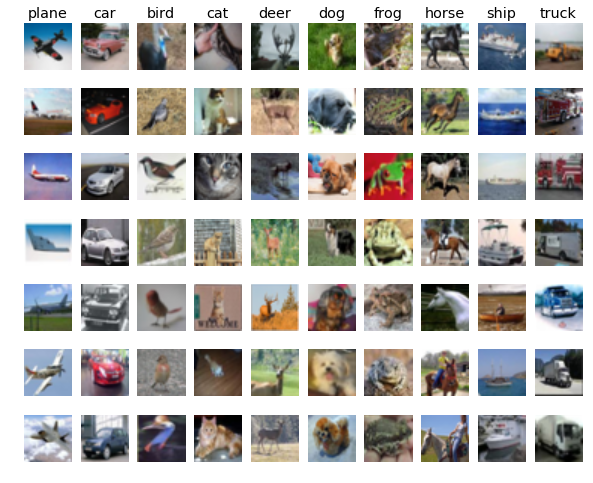

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice( idxs, samples_per_class, replace = False )
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise.
num_training = 49000
num_validation = 1000
num_test = 1000

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print( 'Train data shape: ', X_train.shape )
print( 'Train labels shape: ', y_train.shape )
print( 'Validation data shape: ', X_val.shape )
print( 'Validation labels shape: ', y_val.shape )
print( 'Test data shape: ', X_test.shape )
print( 'Test labels shape: ', y_test.shape )

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print( 'Training data shape: ', X_train.shape )
print( 'Validation data shape: ', X_val.shape )
print( 'Test data shape: ', X_test.shape )

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


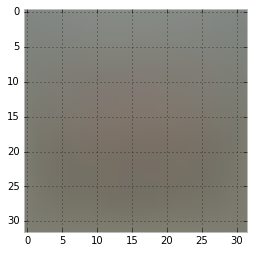

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean( X_train, axis = 0 )
print(mean_image[:10]) # print a few of the elements
plt.figure( figsize = ( 4, 4 ) )
plt.imshow( mean_image.reshape( ( 32, 32, 3 ) ).astype('uint8') ) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# Also, lets transform both data matrices so that each image is a column.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T

print( X_train.shape, X_val.shape, X_test.shape )

(3073, 49000) (3073, 1000) (3073, 1000)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [10]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn( 10, 3073 ) * 0.0001 
loss, grad = svm_loss_naive( W, X_train, y_train, 0.00001 )
print( 'loss: %f' % (loss, ) )

loss: 10.127106


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [11]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive( W, X_train, y_train, reg = 0.0 )

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_train, y_train, reg = 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.476515 analytic: 2.476293, relative error: 4.479869e-05
numerical: -6.513606 analytic: -6.514058, relative error: 3.470909e-05
numerical: 12.408710 analytic: 12.408702, relative error: 3.268672e-07
numerical: -14.727466 analytic: -14.728178, relative error: 2.418333e-05
numerical: -0.672883 analytic: -0.671679, relative error: 8.950571e-04
numerical: 6.084032 analytic: 6.085250, relative error: 1.001055e-04
numerical: 16.419350 analytic: 16.420298, relative error: 2.887821e-05
numerical: 21.986890 analytic: 21.987783, relative error: 2.028584e-05
numerical: 25.555715 analytic: 25.556287, relative error: 1.118854e-05
numerical: 2.792904 analytic: 2.792641, relative error: 4.714193e-05


### Inline Question 1:

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

This shouldn't be reason for concern. Discrepancy may be caused by numerical error (e.g. choice of h too big) and discrepancies with the subgradient since this is not strictly differentiable function. Any function that has this property can cause a gradient check to fail easily.

In [12]:
# Next implement the function svm_loss_vectorized; 
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print( 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic) )

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print( 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic) )

# The losses should match but your vectorized implementation should be much faster.
print( 'difference: %f' % (loss_naive - loss_vectorized) )

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm( grad_naive - grad_vectorized, ord = 'fro')
print( 'difference: %f' % difference )

Naive loss: 1.012711e+01 computed in 2.733683s
Vectorized loss: 9.127106e+00 computed in 0.254435s
difference: 1.000000
difference: 0.000000


## Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train( X_train, y_train, learning_rate = 1e-7, reg = 5e4,
                       num_iters = 1500, verbose = True )
toc = time.time()
print( 'That took %fs' % (toc - tic) )

iteration 0 / 1500: loss 779.406945
iteration 100 / 1500: loss 285.414393
iteration 200 / 1500: loss 106.550425
iteration 300 / 1500: loss 42.180767
iteration 400 / 1500: loss 18.747617
iteration 500 / 1500: loss 10.046553
iteration 600 / 1500: loss 7.381691
iteration 700 / 1500: loss 5.327630
iteration 800 / 1500: loss 5.501078
iteration 900 / 1500: loss 5.898574
iteration 1000 / 1500: loss 5.474041
iteration 1100 / 1500: loss 5.388032
iteration 1200 / 1500: loss 5.610928
iteration 1300 / 1500: loss 5.929692
iteration 1400 / 1500: loss 5.223958
That took 14.142960s


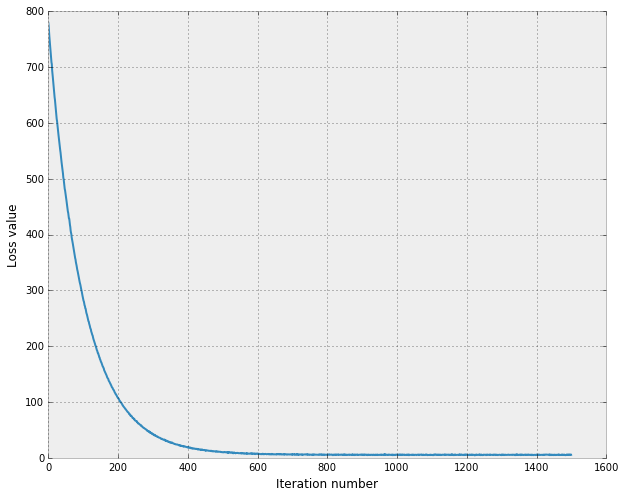

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print( 'training accuracy: %f' % ( np.mean(y_train == y_train_pred), ) )
y_val_pred = svm.predict(X_val)
print( 'validation accuracy: %f' % ( np.mean(y_val == y_val_pred), ) )

training accuracy: 0.369061
validation accuracy: 0.371000


In [17]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths
learning_rates = [ 1e-7, 5e-5 ]
regularization_strengths = [ 5e4, 1e5 ]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_valid = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.


# TODO:
# Write code that chooses the best hyperparameters by tuning on the validation
# set. For each combination of hyperparameters, train a linear SVM on the
# training set, compute its accuracy on the training and validation sets, and
# store these numbers in the results dictionary. In addition, store the best
# validation accuracy in best_val and the LinearSVM object that achieves this 
# accuracy in best_svm
iters = 2000
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        svm.train( X_train, y_train, learning_rate = lr, reg = rs, num_iters = iters )
        
        y_train_pred = svm.predict(X_train)
        y_valid_pred = svm.predict(X_val)
        train_accuracy = np.mean( y_train == y_train_pred )       
        valid_accuracy = np.mean( y_val == y_valid_pred )
        
        results[(lr, rs)] = ( train_accuracy, valid_accuracy )        
        if best_valid < valid_accuracy:
            best_valid = valid_accuracy
            best_svm = svm

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, valid_accuracy = results[(lr, reg)]
    print( 'lr %e reg %e train accuracy: %f valid accuracy: %f' % (
                lr, reg, train_accuracy, valid_accuracy) )
    
print( 'best validation accuracy achieved during cross-validation: %f' % best_val )

lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.367041 valid accuracy: 0.373000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.352837 valid accuracy: 0.356000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 valid accuracy: 0.087000
lr 5.000000e-05 reg 1.000000e+05 train accuracy: 0.100265 valid accuracy: 0.087000
best validation accuracy achieved during cross-validation: -1.000000


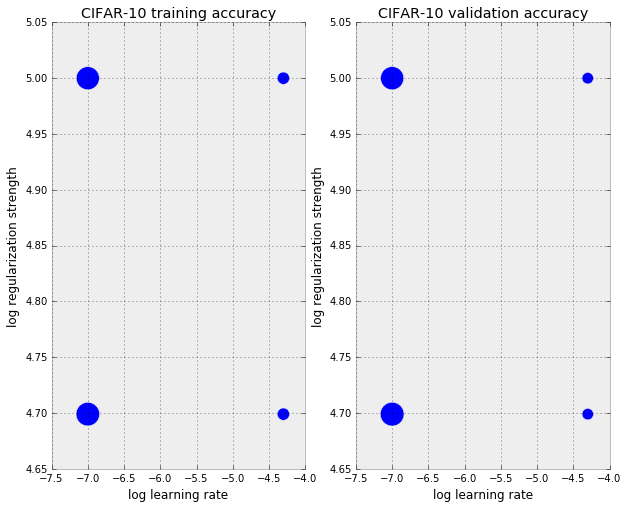

In [18]:
# Visualize the cross-validation results
x_scatter = [np.log10(x[0]) for x in results]
y_scatter = [np.log10(x[1]) for x in results]

# plot training accuracy
sz = [results[x][0]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,1)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
sz = [results[x][1]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,2)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [19]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print( 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy )

linear SVM on raw pixels final test set accuracy: 0.373000


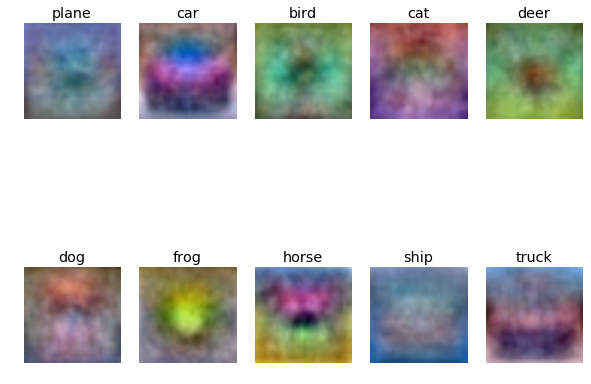

In [20]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do?

The visulized SVM weights look like crude low-resolution templates of the object classes they describe along with the backgrounds they typically occur with. Due to sampling and the model, the templates are very noisy. We see the horse weights, for example, shows what looks like two heads in both directions.

## Reference

Standford CS231n: Convolutional Neural Networks for Visual Recognition

- [Course Notes: linear classification](http://cs231n.github.io/linear-classify/)
- [Course Notes: optimization](http://cs231n.github.io/optimization-1/)
- [Course Home Page](http://cs231n.stanford.edu/index.html)
- [Course Github](https://github.com/cs231n/cs231n.github.io)
- [Course Youtube](https://www.youtube.com/watch?v=NfnWJUyUJYU&list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC)